# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

К вам как опытному дата-сайентисту обратилась страховая компания. Ей необходимо исследовать влияние характеристик клиентов, которых она обслуживает, на размер страховых выплат, которые выплачивают эти клиенты за год, а также отследить иные взаимосвязи в данных.

Страховая компания хочет ответить на следующие вопросы, касающиеся страховых выплат:

- Размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин?
- Размер страховых выплат для некурящих клиентов меньше, чем для курящих?
- Влияет ли регион проживания на размер выплат?
- Есть ли взаимосвязь между курением и полом?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о годовых страховых выплатах с указанием характеристик клиентов.

Данные содержат следующие столбцы:
*   *age* — возраст;
*   *sex* — пол: женский (female), мужской (male);
*   *bmi* — индекс массы тела, показывающий степень соответствия веса человека его росту (нормальные значения — от 18.5 до 24.9 кг/м²);
*   *children* — количество детей или иждивенцев, дополнительно включённых в страховку;
*   *smoker* — курит ли клиент (yes/no);
*   *region* — регион проживания в США: северо-восток (northeast), юго-восток (southeast), юго-запад (southwest), северо-запад (northwest);
*   *charges* — размер страховых выплат на клиента за год.

Источник датасета: ["Medical Cost Personal Datasets" (kaggle.com)](https://www.kaggle.com/datasets/mirichoi0218/insurance/)

## Загрузка данных

In [4]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы в Google Drive, они доступны по [ссылке](https://drive.google.com/file/d/1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r/view).

Для скачивания данных используйте команду `!wget`.

Данные появятся в локальной директории.

In [5]:
# скачиваем датасет 

# в ссылке указан id файла на Google Drive "1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r", id файла взят из ссылки на файл https://drive.google.com/file/d/1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r/view
!wget "https://drive.google.com/uc?export=download&id=1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r" -O insurance.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# загружаем датасет
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


В датасете 1338 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [9]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 1
Размер таблицы после удаления дубликатов: (1337, 7)


### Распределение страховых выплат по всем клиентам

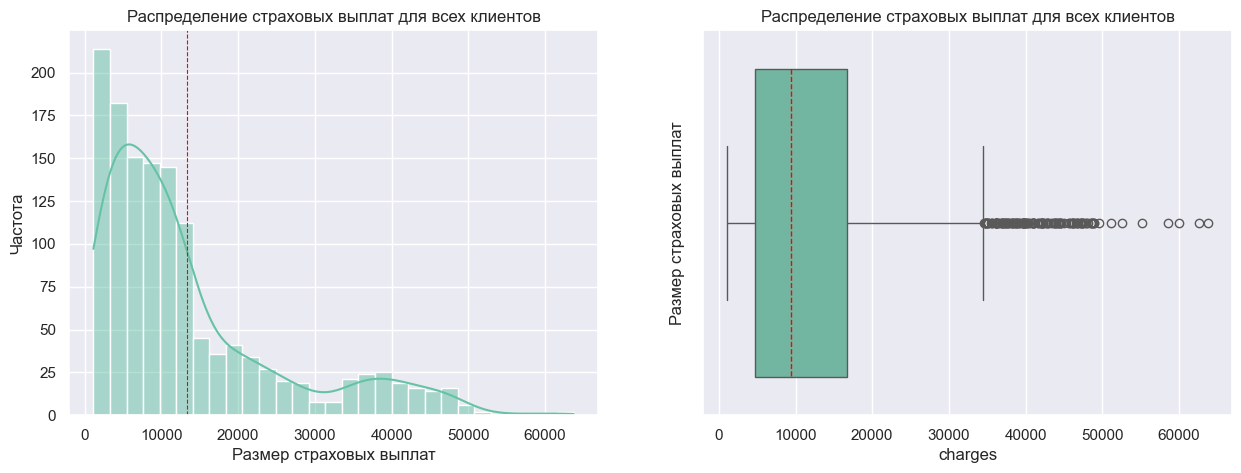

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['charges'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер страховых выплат', ylabel='Частота')
axes[0].set_title('Распределение страховых выплат для всех клиентов')
axes[0].axvline(data['charges'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['charges'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер страховых выплат')
axes[1].set_title('Распределение страховых выплат для всех клиентов')

plt.show()

In [11]:
data_agg = data['charges'].describe().round(2).to_frame()
data_agg.columns = ['Размер страховых выплат']
data_agg

,Размер страховых выплат
count,1337.00
mean,13279.12
std,12110.36
min,1121.87
25%,4746.34
50%,9386.16
75%,16657.72
max,63770.43


Распределение страховых выплат отлично от нормального, имеются выбросы.

### Страховые выплаты в зависимости от пола

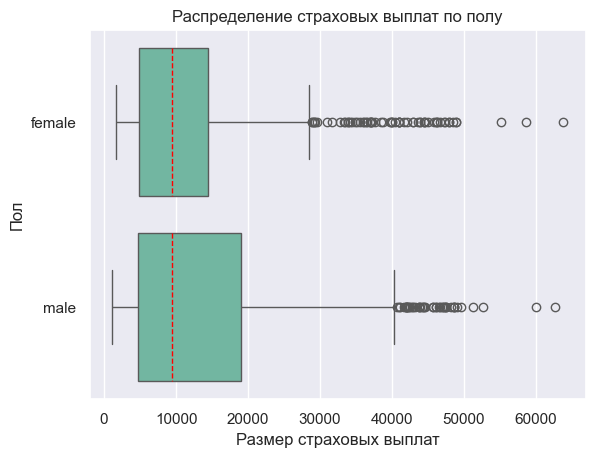

In [12]:
ax = sns.boxplot(data, x='charges', y='sex', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Пол')
plt.title('Распределение страховых выплат по полу')
plt.show()

In [13]:
data_agg = data.groupby('sex')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от пола')
data_agg

Страховые выплаты в зависимости от пола


,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,12569.58,11128.70,1607.51,4885.16,9412.96,14454.69,63770.43
male,675.0,13975.00,12971.96,1121.87,4654.02,9377.90,19006.69,62592.87


На первый взгляд распределения страховых выплат для разных полов различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Страховые выплаты в зависимости от того, курит ли клиент.

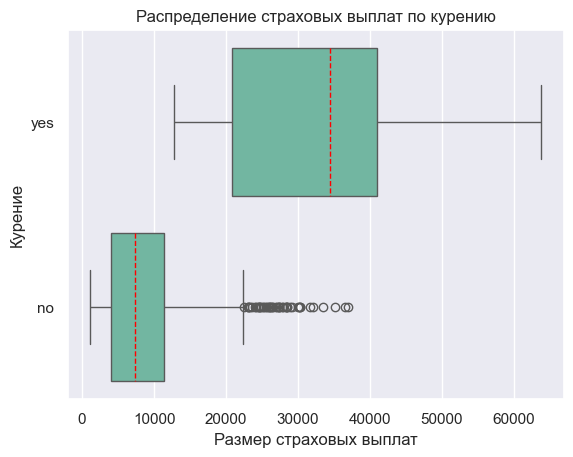

In [14]:
ax = sns.boxplot(data, x='charges', y='smoker', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Курение')
plt.title('Распределение страховых выплат по курению')
plt.show()

In [15]:
data_agg = data.groupby('smoker')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от курения')
data_agg

Страховые выплаты в зависимости от курения


,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1063.0,8440.66,5992.97,1121.87,3988.88,7345.73,11363.02,36910.61
yes,274.0,32050.23,11541.55,12829.46,20826.24,34456.35,41019.21,63770.43


Распределения страховых выплат различны в зависимости от того, курит ли клиент. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Страховые выплаты в зависимости от региона

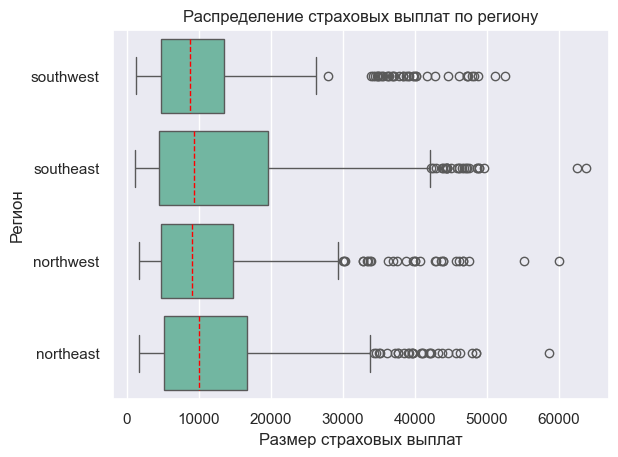

In [16]:
ax = sns.boxplot(data, x='charges', y='region', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Регион')
plt.title('Распределение страховых выплат по региону')
plt.show()

In [17]:
data_agg = data.groupby('region')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от региона')
data_agg

Страховые выплаты в зависимости от региона


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,324.0,13406.38,11255.80,1694.80,5194.32,10057.65,16687.36,58571.07
northwest,324.0,12450.84,11073.13,1621.34,4733.64,8976.98,14788.75,60021.40
southeast,364.0,14735.41,13971.10,1121.87,4440.89,9294.13,19526.29,63770.43
southwest,325.0,12346.94,11557.18,1241.56,4751.07,8798.59,13462.52,52590.83


Распределения страховых выплат различны для разных регионов. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение курящих среди мужчин и женщин

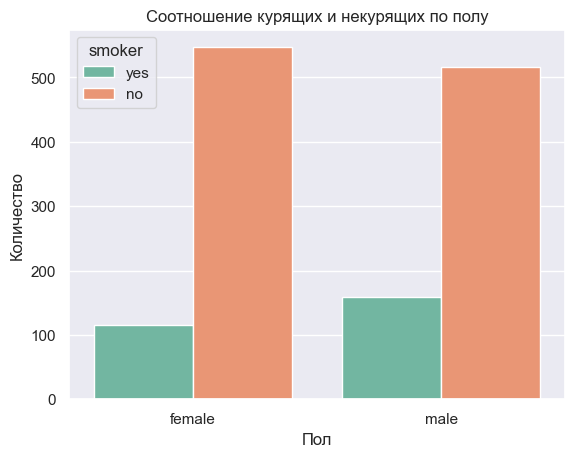

In [18]:
ax = sns.countplot(data=data, x=data['sex'], hue='smoker')
ax.set(xlabel='Пол', ylabel='Количество')
plt.title('Соотношение курящих и некурящих по полу')
plt.show()

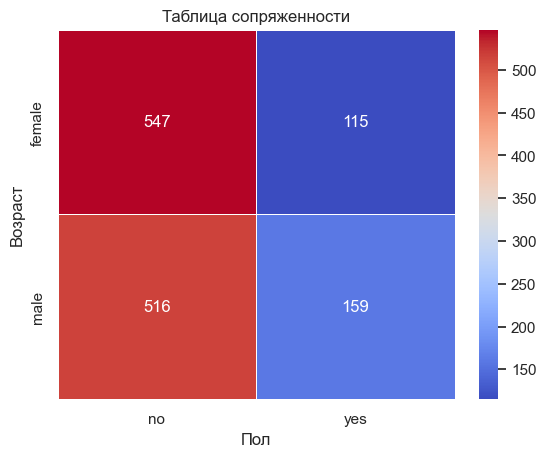

In [19]:
cross_tab = pd.crosstab(index=data['sex'], columns=data['smoker'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Пол', ylabel='Возраст')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, среди курящих мужчин больше, чем женщин. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [20]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически меньше либо равен размеру страховых выплат клиентов-женщин ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически больше, чем размер страховых выплат клиентов-женщин ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [21]:
# значения страховых выплат
charges_male = data.loc[data['sex']=='male', 'charges']
charges_female = data.loc[data['sex']=='female', 'charges']

# проводим тест Шапиро-Уилка
print('Для мужчин:')
result = stats.shapiro(charges_male)
decision_normality(result[1])

print('Для женщин:')
result = stats.shapiro(charges_female)
decision_normality(result[1])

Для мужчин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для женщин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [22]:
# проводим тест
_, p = stats.mannwhitneyu(charges_male, charges_female, alternative='greater')
decision_hypothesis(p)

p-value = 0.347
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин.

### Размер страховых выплат для некурящих клиентов меньше, чем для курящих?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически больше либо равен размеру страховых выплат для курящих клиентов ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически меньше, чем размер страховых выплат для курящих клиентов ($μ_2$).
$$ H_1 : μ_1 < μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [23]:
# значения страховых выплат
charges_no_smoker = data.loc[data['smoker']=='no', 'charges']
charges_smoker = data.loc[data['smoker']=='yes', 'charges']

# проводим тест Шапиро-Уилка
print('Для некурящих клиентов:')
result = stats.shapiro(charges_no_smoker)
decision_normality(result[1])

print('Для курящих клиентов:')
result = stats.shapiro(charges_smoker)
decision_normality(result[1])

Для некурящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для курящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [24]:
# проводим тест
_, p = stats.mannwhitneyu(charges_no_smoker, charges_smoker, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер страховых выплат для некурящих клиентов меньше, чем для курящих.

### Влияет ли регион проживания на размер выплат?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер страховых выплат не отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер страховых выплат отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [25]:
# значения страховых выплат
charges_northeast = data.loc[data['region']=='northeast', 'charges']
charges_southeast = data.loc[data['region']=='southeast', 'charges']
charges_northwest = data.loc[data['region']=='northwest', 'charges']
charges_southwest = data.loc[data['region']=='southwest', 'charges']

# проводим тест Шапиро-Уилка
print('Для северо-востока:')
result = stats.shapiro(charges_northeast)
decision_normality(result[1])

print('Для юго-востока:')
result = stats.shapiro(charges_southeast)
decision_normality(result[1])

print('Для северо-запада:')
result = stats.shapiro(charges_northwest)
decision_normality(result[1])

print('Для юго-запада:')
result = stats.shapiro(charges_southwest)
decision_normality(result[1])


Для северо-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для северо-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Регион проживания в США»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [26]:
# проводим тест
_, p = stats.kruskal(charges_northeast, charges_southeast, charges_southwest, charges_northwest)
decision_hypothesis(p)

p-value = 0.202
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что есть разница в размере страховых выплат в разных регионах.

### Есть ли взаимосвязь между курением и полом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, курит человек или нет, и его полом нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, курит человек или нет, и его полом есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [27]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['sex'], data['smoker'])

cross_table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [28]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между полом и курением.

## Итоговые результаты исследования

*   Нет оснований утверждать, что есть разница в размере страховых выплат для клиентов-мужчин и клиентов-женщин.
*   Размер страховых выплат для некурящих клиентов меньше, чем для курящих.
*   Нет оснований утверждать, что есть разница в размере страховых выплат для разных регионов.
*   Существует взаимосвязь между полом и курением.